# Sequential Convex Programming for Trajectory Generation

<img src="sim/gifs/quad_flight.gif" width="800" align="center">

## General

### User input

In [897]:
save_fig = True
save_anim = False
fig_format = ['pdf', 'png'][0]
fig_png_dpi = 600

### Libraries

In [898]:
import numpy as np
import cvxpy as cp
import time
from cvxpygen import cpg

import jax
import jax.numpy as jnp
from jax import jit, jacfwd, vmap, lax, config
from jax.lax import cond
from jaxlib.xla_extension import ArrayImpl
config.update("jax_enable_x64", True)

import os
import glob
import copy
import pickle
import warnings
import typing as T
from tqdm import tqdm
from PIL import Image

import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d.art3d import Line3DCollection

mpl.rcParams['figure.dpi'] = 120 
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']}) ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['tab:red', 'k', 'tab:green', 'tab:blue', 'tab:grey'])
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'legend.fontsize': 11})
mpl.rcParams.update({'axes.xmargin': 0})
mpl.rcParams.update({'lines.solid_capstyle': 'round'})
mpl.rcParams.update({'lines.solid_joinstyle': 'round'})
mpl.rcParams.update({'lines.dash_capstyle': 'round'})
mpl.rcParams.update({'lines.dash_joinstyle': 'round'})
mpl.rcParams.update({'text.latex.preamble': r"\usepackage{bm}"})

warnings.filterwarnings("ignore")

### D-GMSR

In [899]:
def gmsr_and_jax(eps: float,
                 p: int,
                 weights: jnp.ndarray,
                 *args: T.Tuple[T.Any]) -> T.Any:
    '''
    Input: The values of the functions to be connected with AND -> (f, g, h, ...)
    Output: gmsr_and function's value
    '''
    
    fcn_vals = args[0]
    
    # Masks for positive and negative elements
    pos_mask = fcn_vals > 0
    # neg_mask = ~pos_mask
    neg_mask = fcn_vals <= 0

    # Values and weights partitioned by positive and negative masks
    pos_vals = jnp.where(pos_mask, fcn_vals, 0.0)
    neg_vals = jnp.where(neg_mask, fcn_vals, 0.0)
    
    pos_w = jnp.where(pos_mask, weights, 0.0)
    neg_w = jnp.where(neg_mask, weights, 0.0)
    
    sum_w = weights.sum()

    # Conditional computation using jax.cond
    def compute_neg_case(ada):
        sums = jnp.sum(neg_w * (neg_vals**(2 * p)))
        Mp = (eps**p + (sums / sum_w))**(1/p)
        return eps**(1/2) - Mp**(1/2)
    
    def compute_pos_case(ada):
        # mult = jnp.prod((pos_vals)**(2 * pos_w))
        mult = jnp.exp(jnp.sum(2 * pos_w * jnp.log(pos_vals)))
        M0 = (eps**sum_w + mult)**(1/sum_w)
        return M0**(1/2) - eps**(1/2)
    
    # Choose which branch to execute
    h_and = cond(jnp.any(neg_mask), compute_neg_case, compute_pos_case, operand=None)

    return h_and

def gmsr_or_jax(eps: float, p: int, weights: jnp.ndarray, *args: T.Tuple[T.Any]) -> T.Any:
    '''
    Input: The values of the functions to be connected with OR
    Output: gmsr_or function's value
    '''
    
    neg_args = -jnp.array(args[0])
    h_mor = gmsr_and_jax(eps, p, weights, neg_args)
    return -h_mor

In [900]:
def UNTIL_jax(
    eps: float,
    p: int,
    w_f: jnp.ndarray,
    w_g: jnp.ndarray,
    w_fg: jnp.ndarray,
    f: jnp.ndarray,
    g: jnp.ndarray,
) -> T.Any:
    
    K = f.shape[0]
    s = jnp.zeros(K)

    def body(i, s):
        y_i = gmsr_and_jax(eps, p, w_f[:i+1], f[:i+1])
        s_i = gmsr_and_jax(eps, p, w_fg[:2], jnp.array([y_i, g[i]]))
        s = s.at[i].set(s_i)
        return s

    s = jax.lax.fori_loop(0, K, body, s)
    z = gmsr_or_jax(eps, p, w_g, s)
    return z

### Profiling

In [901]:
def profile_with_cprofile(func, *args, filename="profiling_results.prof", **kwargs):
    import cProfile
    pr = cProfile.Profile()
    pr.enable()
    result = func(*args, **kwargs)
    if hasattr(result, "block_until_ready"):
        result.block_until_ready()
    pr.disable()
    pr.dump_stats(filename)
    return result

### Animation maker

In [902]:
def make_anim(load_from, save_to, duration, fps, anim_format):

    if anim_format == 'gif':
        frames = [Image.open(image) for image in sorted(glob.glob(f"{load_from}/*"+".png"))][::2]
        frame_one = frames[0]
        frame_one.save(save_to + ".gif", format="GIF", 
                       append_images=frames, save_all=True, 
                       duration=duration, loop=0)
    
    elif anim_format == 'mp4':
        # Get the list of image frames
        frames = sorted(glob.glob(f"{load_from}/*.png"))

        # Read the first frame to get frame dimensions
        first_frame = cv2.imread(frames[0])
        height, width, layers = first_frame.shape

        # Define the codec and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify MP4 codec
        video = cv2.VideoWriter(save_to + ".mp4", fourcc, fps, (width, height))

        # Add all frames to the video
        for frame in frames:
            img = cv2.imread(frame)
            video.write(img)

        # Release the video writer
        video.release()

### Print

In [903]:
def dict_append(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

    return dict

def update_cost_dict(d, **kwargs):
    key_map = {
        'T_Ite': 'T-Ite',
        'T_Disc': 'T-Disc',
        'T_SubP': 'T-SubP',
        'D_NL': 'D-NL',
        'D_L': 'D-L',
        'W_TR': 'W-TR',
        'Note': 'Note',
        'Rho': 'Rho',
        'Ite': 'Ite',
    }
    for key, val in kwargs.items():
        d = dict_append(d, key_map.get(key, key), val)
    return d

def print_ite(log_ite_all):

    col_width = int(1 * max(len(ele) for ele in log_ite_all.keys() if ele is not None)) + 4

    if log_ite_all['Note'][-1] == 'Start':
        all_dum = ''
        for key in log_ite_all.keys():
            all_dum += key.ljust(col_width)
        print(all_dum)

    all_dum = ''
    for key in log_ite_all.keys():
        if type(log_ite_all[key]) == list:
            dum = log_ite_all[key][-1]
            if isinstance(dum, ArrayImpl):
                dum = float(dum)
            if isinstance(dum, float):
                dum = round(dum, 2)
                dum = min(dum, 999999.99)

        all_dum += str(dum).ljust(col_width)
    print(all_dum)

## Succeessive Convexification

### Integration

In [904]:
def rk4(func : T.Any,
        y0 : np.ndarray, 
        tf : float, 
        steps : int, 
        *args : T.Tuple[T.Any]) -> np.ndarray:
    """
    Implementation of the fourth-order Runge-Kutta (RK4) method for numerical integration.

    Parameters:
    - f: Function representing the system of ordinary differential equations (ODEs).
    - y0: Initial conditions (numpy array, n-dimensional column vector).
    - t: Time points for which the solution is calculated.

    Returns:
    - y: Solution of the ODEs at each time point.
    """

    t = np.linspace(0, tf, int(steps))  # Time points

    # Ensure y0 is a NumPy array (n-dimensional column vector)
    y0 = y0.reshape(-1, 1)

    # Initialize solution array
    y = np.zeros((len(t), len(y0)))
    y[0, :] = y0.flatten()

    # Perform RK4 integration
    for i in range(len(t) - 1):

        h = t[i + 1] - t[i]
        k1 = h * func(y[i], t[i], args)
        k2 = h * func(y[i] + 0.5 * k1, t[i] + 0.5 * h, args)
        k3 = h * func(y[i] + 0.5 * k2, t[i] + 0.5 * h, args)
        k4 = h * func(y[i] + k3, t[i] + h, args)

        y[i + 1, :] = y[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return y

def dxdt(x : np.ndarray,
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:

    """
    return: x_dot(t)
    """

    tt, tf, u_0, u_1, params = args[0]
    
    if params['inp_param'] == 'FOH':
        u = u_0 + (t / tf) * (u_1 - u_0)
    elif params['inp_param'] == 'ZOH':
        u = u_0.copy()

    return params['f_func'](x, u)

def integrate_dynamics(x : np.ndarray,
                       u_0 : np.ndarray,
                       u_1 : np.ndarray,
                       params : T.Dict[str, T.Any],
                       tf : float,
                       tt : float,
                      ) -> T.Tuple[np.ndarray]:
    """
    Integration of the vehicle dynamics [0, tf]
    return: x[t+dt] and u
    """
    x_next = rk4(dxdt, x, tf, params['rk4_steps_dyn'], tt, tf, u_0, u_1, params)[-1,:]
    return x_next

In [905]:
def rk4_jax(func, y0, tf, steps, *args):
    h = tf / (steps - 1)
    t = jnp.arange(steps) * h

    def step(y_t, t_i):
        y, _ = y_t
        k1 = h * func(y, t_i, *args)
        k2 = h * func(y + 0.5 * k1, t_i + 0.5 * h, *args)
        k3 = h * func(y + 0.5 * k2, t_i + 0.5 * h, *args)
        k4 = h * func(y + k3, t_i + h, *args)
        y_next = y + (k1 + 2*k2 + 2*k3 + k4) / 6.
        return (y_next, t_i), y_next

    (_, _), ys = lax.scan(step, (y0, t[0]), t[:-1])
    ys = jnp.vstack([y0[None, :], ys])
    return ys

def dxdt_jax(x, t, tt, tf, u_k, u_kp1, params):
    
    if params['inp_param'] == 'FOH':
        u = u_k + (t / tf) * (u_kp1 - u_k)
    elif params['inp_param'] == 'ZOH':
        u = u_k
    return params['f_func'](x, u)

def integrate_multiple(X, U, sigma, params):

    if params['free_final_time']:
        if params['time_dil']:
            sigma_vec = sigma[0]
        else:
            sigma_k = sigma / (params['K'] - 1)
            sigma_vec = jnp.ones((params['K'] - 1)) * sigma_k
    else:
        sigma_k = params['t_scp']
        sigma_vec = jnp.ones((params['K'] - 1)) * sigma_k

    tt_vec = jnp.cumsum(jnp.concatenate([jnp.zeros((1,)), sigma_vec]))[:-1]

    def body(k):
        x_k = X[:, k]
        u_k = U[:, k]
        u_kp1 = U[:, k + 1]

        sigma_k = sigma_vec[k]  # if needed
        tt = tt_vec[k]

        return rk4_jax(dxdt_jax, x_k, sigma_k, params['rk4_steps_dyn'], tt, sigma_k, u_k, u_kp1, params)[-1]
    
    x_next = vmap(body)(jnp.arange(params['K'] - 1))
    return x_next.T

### Discretization

In [906]:
def dVdt(V, t, u_0, u_1, sigma, tt, params):

    n_x = params['n_x']
    n_u = params['n_u']
    K = params['K']

    i0 = params['i0']
    i1 = params['i1']
    i2 = params['i2']
    i3 = params['i3']
    i4 = params['i4']
    i5 = params['i5']
    i6 = params['i6']

    x = V[i0:i1]

    if params['inp_param'] == 'ZOH':
        beta = 0.
    elif params['inp_param'] == 'FOH':
        beta = t / params['t_scp']
        if params['free_final_time']:
            if params['time_dil']:
                beta = t
            else:
                beta = (t / (1 / (K- 1)))

    alpha = 1 - beta
    u = u_0 + beta * (u_1 - u_0)

    A_subs = sigma * params['A_func'](x, u)
    B_subs = sigma * params['B_func'](x, u)
    f_subs = params['f_func'](x, u)

    z_t = jnp.where(
        params['free_final_time'],
        -A_subs @ x - B_subs @ u,
        f_subs - A_subs @ x - B_subs @ u
    )

    dVdt_parts = [
        sigma * f_subs.T,
        (A_subs @ V[i1:i2].reshape(n_x, n_x)).reshape(-1),
        (A_subs @ V[i2:i3].reshape(n_x, n_u) + B_subs * alpha).reshape(-1),
        (A_subs @ V[i3:i4].reshape(n_x, n_u) + B_subs * beta).reshape(-1),
        (A_subs @ V[i4:i5] + f_subs).reshape(-1),
        (A_subs @ V[i5:i6] + z_t).reshape(-1)
    ]
    return jnp.concatenate(dVdt_parts)

def calculate_discretization(X, U, sigma, params):
    
    n_x = params['n_x']
    n_u = params['n_u']
    K = params['K']

    i0 = params['i0']
    i1 = params['i1']
    i2 = params['i2']
    i3 = params['i3']
    i4 = params['i4']
    i5 = params['i5']
    i6 = params['i6']

    def single_step(k):
        x_k = X[:, k]
        u0 = U[:, k]
        u1 = U[:, k + 1]

        if params['free_final_time']:
            if params['time_dil']:
                t_scp = 1.
                tt = jnp.cumsum(jnp.concatenate((jnp.zeros(1), sigma[0, :])))
                tt_k = tt[k]
                sigma_k = sigma[0, k]
            else:
                t_scp = 1. / (K - 1)
                tt_k = k * sigma / (K - 1)
                sigma_k = sigma
        else:
            t_scp = params['t_scp']
            tt_k = k * t_scp
            sigma_k = 1.

        V0 = jnp.concatenate([
            x_k,                                 # i0:i1
            jnp.eye(n_x).reshape(-1),            # i1:i2
            jnp.zeros(i6 - i2)                   # rest: i2 onward
        ])
        
        V = rk4_jax(dVdt, V0, t_scp, params['rk4_steps_J'], u0, u1, sigma_k, tt_k, params)[-1]

        return {
            'f_bar': V[i0:i1],
            'A_bar': V[i1:i2].reshape((n_x, n_x)).flatten(order='F'),
            'B_bar': V[i2:i3].reshape((n_x, n_u)).flatten(order='F'),
            'C_bar': V[i3:i4].reshape((n_x, n_u)).flatten(order='F'),
            'S_bar': V[i4:i5],
            'z_bar': V[i5:i6],
        }

    results = jax.vmap(single_step)(jnp.arange(K - 1))

    params_z = {
        'f_bar': results['f_bar'].T,
        'A_bar': results['A_bar'].T,
        'B_bar': results['B_bar'].T,
        'C_bar': results['C_bar'].T,
        'S_bar': results['S_bar'].T,
        'z_bar': results['z_bar'].T,
    }
    
    return params_z

### Jitting function

In [907]:
def make_non_lin_fn(jax_fcn, params):
    def non_lin_loss(X_last):
        return jax_fcn(X_last, params)

    non_lin_loss_jitted = jax.jit(non_lin_loss).lower(
        params['X_last']).compile()
    grad_non_lin_loss_jitted = jax.jit(jax.jacfwd(non_lin_loss)).lower(
        params['X_last']).compile()
    
    return non_lin_loss_jitted, grad_non_lin_loss_jitted

def make_calc_fn_cd(params):
    def calculate_discretization_wrapped(X, U, sigma):
        return calculate_discretization(X, U, sigma, params)
    return jit(calculate_discretization_wrapped).lower(
                    params['X_last'],
                    params['U_last'],
                    params['sigma_last']).compile()

def make_calc_fn_im(params):
    def integrate_multiple_wrapped(X, U, sigma):
        return integrate_multiple(X, U, sigma, params)
    return jit(integrate_multiple_wrapped).lower(
                    params['X_last'],
                    params['U_last'],
                    params['sigma_last']).compile()

def f_gf_non_lin_np(X_last, params, non_lin_loss_jitted, grad_non_lin_loss_jitted):
    f_non_lin_jax = non_lin_loss_jitted(X_last)
    gf_non_lin_jax = grad_non_lin_loss_jitted(X_last)

    f_non_lin_np = np.asarray(f_non_lin_jax).reshape((params['N_non_lin'],))
    gf_non_lin_np = np.asarray(gf_non_lin_jax).transpose(0, 2, 1).reshape(params['N_non_lin'], params['n_x'] * params['K'])

    return f_non_lin_np, gf_non_lin_np

### Linear / Nonlinear Cost

In [908]:
def scp_non_linear_cost(X_new : np.ndarray,
                        U_new : np.ndarray,
                        sigma_new : np.ndarray,
                        X_last : np.ndarray,
                        U_last : np.ndarray,
                        sigma_last : np.ndarray,
                        nu_new : np.ndarray,
                        nl_nu_new : np.ndarray,
                        w_tr : float,
                        params : T.Dict[str, T.Any],
                        cost_dict : T.Dict[str, T.Any],
                       ) -> T.Tuple[np.ndarray]:
    """
    Returns the nonlinear or linearized cost value of the SCP problem
    Required for prox-linear with adaptive step-size
    """

    dx = X_new - X_last
    du = U_new - U_last
    ds = 0.
    if params['free_final_time']:
        ds = (sigma_new - sigma_last) / params['t_f'] * params['w_ds']

        if params['time_dil']:
            cp_sum = np.linalg.norm(ds[0,:], axis=0)**2
        else:
            cp_sum = np.abs(ds)**2
    else:
        cp_sum = 0.

    ptr_cost = w_tr * ( np.linalg.norm(dx, axis=0)**2 + np.linalg.norm(du, axis=0)**2 + cp_sum).sum()

    lcd = params['w_con_dyn'] * np.linalg.norm(nu_new.reshape(-1), 1)
    nlcd = params['w_con_dyn'] * np.linalg.norm(nl_nu_new.reshape(-1), 1)

    lin_vehicle_cost = params['vehicle_cost_fcn'](X_new, U_new, sigma_new, X_last, U_last, sigma_last, nu_new, params, npy=True)
    n_lin_vehicle_cost, cost_dict = params['vehicle_cost_fcn'](X_new, U_new, sigma_new, X_new, U_new, sigma_new, nl_nu_new, params, npy=True, cost_dict=cost_dict)

    lin_cost = lcd + lin_vehicle_cost
    n_lin_cost = nlcd + n_lin_vehicle_cost

    cost_dict = dict_append(cost_dict, 'ptr_cost', ptr_cost)
    cost_dict = dict_append(cost_dict, 'lcd', lcd)
    cost_dict = dict_append(cost_dict, 'nlcd', nlcd)
    
    cost_dict = dict_append(cost_dict, 'lc', lin_cost)
    cost_dict = dict_append(cost_dict, 'nlc', n_lin_cost)

    return cost_dict

### Convex Problem (sub-problem)

In [909]:
def solve_convex_problem(X_last : np.ndarray,
                         U_last : np.ndarray,
                         sigma_last : np.ndarray,
                         w_tr : float,
                         params : T.Dict[str, T.Any],
                        ) -> T.Tuple[np.ndarray]:
       
    """
    Solves the convex sub-problem using CLARABEL or ECOS and retruns the optimal values of X, U, sigma and nu
    """

    n_x = params['n_x']
    n_u = params['n_u']

    X  = cp.Variable((n_x, params['K']))
    U  = cp.Variable((n_u, params['K']))
    nu = cp.Variable((n_x, params['K'] - 1))

    dx = X - X_last
    du = U - U_last
    if params['free_final_time']:
        if (params['time_dil']):
            sigma = cp.Variable((1, params['K'] - 1), nonneg=True)
            sig_time = sigma
            ds = (sigma - sigma_last) / params['t_f'] * params['w_ds']
            cp_sum = cp.sum(cp.norm(ds[0, :], axis=0)**2)
        else:
            sigma = cp.Variable(nonneg=True)
            sig_time = sigma * np.ones((1, params['K'] - 1))
            ds = (sigma - sigma_last) / params['t_f'] * params['w_ds']
            cp_sum = cp.sum(cp.abs(ds)**2)

        S_sigma = cp.multiply(params['S_bar'], ( np.ones( (n_x, 1) ) @ sig_time ))
    else:
        sigma = np.array(0, dtype=np.float64)
        cp_sum = 0.
        S_sigma = np.zeros( (n_x, params['K'] - 1) )

    cost = w_tr * (cp.sum(cp.norm(dx, axis=0)**2) + cp.sum(cp.norm(du, axis=0)**2) + cp_sum) # Trust region

    cost += params['w_con_dyn'] * cp.sum(cp.abs(nu))

    non_lin_cost = params['f_non_lin_np'] + params['gf_non_lin_np'] @ cp.vec(dx, order='F')
    cost += params['w_non_lin'] * cp.sum(cp.pos(non_lin_cost))

    constraints = [
        X[:, k + 1] ==
        cp.reshape(params['A_bar'][:, k], (n_x, n_x)) @ X[:, k]
        + cp.reshape(params['B_bar'][:, k], (n_x, n_u)) @ U[:, k]
        + cp.reshape(params['C_bar'][:, k], (n_x, n_u)) @ U[:, k+1]
        + S_sigma[:, k]
        + params['z_bar'][:, k]
        + nu[:, k]
        for k in range(params['K'] - 1)
    ]

    cost += params['vehicle_cost_fcn'](X, U, sigma, X_last, U_last, sigma_last, nu, params, npy=False)
    constraints += params['vehicle_cons_fcn'](X, U, sigma, X_last, U_last, sigma_last, params, npy=False)
    
    # Create the optimization problem
    problem = cp.Problem(cp.Minimize(cost), constraints)

    # Solve the optimization problem
    try:
        problem.solve(solver='QOCO', verbose=False)
    except:
        problem.solve(solver='ECOS', verbose=False)

    if not(problem.status == 'optimal'): 
        print('*'*50)
        print('-'*20 + 'WARNING' + '-'*20)
        print('Problem status: ', problem.status)
        print('-'*20 + 'WARNING' + '-'*20)
        print('*'*50)

    if params['free_final_time']:
        sigma = sigma.value
    
    return X.value, U.value, sigma, nu.value

In [ ]:
def parse_convex_problem(params : T.Dict[str, T.Any]):
       
    """
    Solves the convex sub-problem using CLARABEL or ECOS and retruns the optimal values of X, U, sigma and nu
    """

    n_x = params['n_x']
    n_u = params['n_u']
    K = params['K']

    var = {}
    par = {}

    var['X']  = cp.Variable((n_x, K), name='X')
    var['U']  = cp.Variable((n_u, K), name='U')
    var['nu'] = cp.Variable((n_x, K - 1), name='nu')
    var['dx']  = cp.Variable((n_x, K), name='dx')
    var['du']  = cp.Variable((n_u, K), name='du')

    par['A_bar'] = cp.Parameter((n_x*n_x, K - 1), name='A_bar')
    par['B_bar'] = cp.Parameter((n_x*n_u, K - 1), name='B_bar')
    par['C_bar'] = cp.Parameter((n_x*n_u, K - 1), name='C_bar')
    par['z_bar'] = cp.Parameter((n_x, K - 1), name='z_bar')

    par['X_last'] = cp.Parameter((n_x, K), name='X_last')
    par['U_last'] = cp.Parameter((n_u, K), name='U_last')
    par['w_tr'] = cp.Parameter(nonneg=True, name='w_tr')
    par['w_con_dyn'] = cp.Parameter(nonneg=True, name='w_con_dyn')

    par['f_non_lin'] = cp.Parameter(params['N_non_lin'], name='f_non_lin')
    par['gf_non_lin_x'] = cp.Parameter((params['N_non_lin'], n_x*K), name='gf_non_lin_x')

    if params['free_final_time']:
        par['S_bar'] = cp.Parameter((n_x, K - 1), name='S_bar')
        if (params['time_dil']):
            var['sigma'] = cp.Variable((1, K - 1), nonneg=True, name='sigma')
            par['sigma_last'] = cp.Parameter((1, K - 1), nonneg=True, name='sigma_last')
            var['ds'] = cp.Variable((1, K - 1), name='ds')

            sig_time = np.ones( (n_x, 1) ) @ var['sigma']
            cp_sum = cp.sum(cp.norm(var['ds'][0, :], axis=0)**2)

        else:
            var['sigma'] = cp.Variable(nonneg=True, name='sigma')
            par['sigma_last'] = cp.Parameter(nonneg=True, name='sigma_last')
            var['ds'] = cp.Variable(nonneg=True, name='ds')

            sig_time = var['sigma'] * np.ones((n_x, K - 1))
            cp_sum = cp.sum(cp.abs(var['ds'])**2)

        S_sigma = cp.multiply(par['S_bar'], sig_time)
    else:
        var['sigma'] = np.array(0, dtype=np.float64)
        par['sigma_last'] = np.array(0, dtype=np.float64)

        cp_sum = 0.
        S_sigma = np.zeros( (n_x, K - 1) )

    cost = par['w_tr'] * (cp.sum(cp.norm(var['dx'], axis=0)**2) + cp.sum(cp.norm(var['du'], axis=0)**2) + cp_sum) # Trust region
    cost += par['w_con_dyn'] * cp.sum(cp.abs(var['nu']))

    non_lin_cost = par['f_non_lin'] + par['gf_non_lin_x'] @ cp.vec(var['dx'], order='F')
    cost += params['w_non_lin'] * cp.sum(cp.pos(non_lin_cost))
    
    constraints = []

    constraints += [
        var['X'][:, k + 1] ==
        cp.reshape(par['A_bar'][:, k], (n_x, n_x)) @ var['X'][:, k]
        + cp.reshape(par['B_bar'][:, k], (n_x, n_u)) @ var['U'][:, k]
        + cp.reshape(par['C_bar'][:, k], (n_x, n_u)) @ var['U'][:, k+1]
        + S_sigma[:, k]
        + par['z_bar'][:, k]
        + var['nu'][:, k]
        for k in range(K - 1)
    ]

    constraints += [
        var['dx'] == var['X'] - par['X_last'],
        var['du'] == var['U'] - par['U_last'],
    ]

    if params['free_final_time']:
        constraints += [
            var['ds'] == (var['sigma'] - par['sigma_last']) / params['t_f'] * params['w_ds']
        ]

    cost += params['vehicle_cost_fcn'](var['X'], var['U'], var['sigma'], 
                                       par['X_last'], par['U_last'], par['sigma_last'], 
                                       var['nu'], params, npy=False)
    constraints += params['vehicle_cons_fcn'](var['X'], var['U'], var['sigma'], 
                                              par['X_last'], par['U_last'], par['sigma_last'], 
                                              params, npy=False)
    
    # Create the optimization problem
    cvx_prb = cp.Problem(cp.Minimize(cost), constraints)

    # print(cvx_prb.is_dcp(dpp=True))

    return cvx_prb

def solve_parsed_problem(cvx_prb):

    cvx_prb.solve(method = 'CPG') # solver='CLARABEL' solver='ECOS'

    X_new = cvx_prb.var_dict['X'].value
    U_new = cvx_prb.var_dict['U'].value
    try:
        sigma_new = cvx_prb.var_dict['sigma'].value
    except:
        sigma_new = np.array(0, dtype=np.float64)
    
    nu_new = cvx_prb.var_dict['nu'].value
    return X_new, U_new, sigma_new, nu_new

def set_parameters(problem, **kwargs):
    for key in kwargs:
        if key in problem.param_dict.keys():
            problem.param_dict[key].value = kwargs[key]

    return problem

### Prox-linear

In [911]:
def prox_linear(params, 
                cvx_prb,
                integrate_multiple_jitted,
                calculate_discretization_jitted,
                non_lin_loss_jitted, 
                grad_non_lin_loss_jitted):

    """
    Solves the non-convex trajectory optimization problem using Penalized Trust Region method (PTR)
    """

    X_last = params['X_last']
    U_last = params['U_last']
    sigma_last = params['sigma_last']
    w_tr = params['w_ptr']
    last_cost = None
    converged = False

    cost_dict = dict()
    ### Start with the following
    cost_dict = update_cost_dict(
        {},
        Ite=0,
        T_Ite=0,
        T_Disc=0,
        T_SubP=0
    )

    # Initial cost value: J(x_0, u_0, simga_0)
    X_nl_ = X_last.copy()
    X_nl_[:, 1:] = integrate_multiple_jitted(X_last, U_last, sigma_last)

    nl_nu_new_ = (X_last - X_nl_)
    params['f_non_lin_np'], params['gf_non_lin_np'] = f_gf_non_lin_np(X_last, params, non_lin_loss_jitted, grad_non_lin_loss_jitted)
    cost_dict = scp_non_linear_cost(X_last, U_last, sigma_last, 
                                    X_last, U_last, sigma_last, 
                                    nl_nu_new_, nl_nu_new_, w_tr, 
                                    params, copy.deepcopy(cost_dict))
    last_cost = cost_dict['nlc'][-1]

    cost_dict = update_cost_dict(
        cost_dict,
        D_NL=0,
        D_L=0,
        Rho=0,
        W_TR=w_tr,
        Note='Start'
    )

    print_ite(cost_dict)
    
    for ite in range(params['ite']):
        t0_ite = time.time()
        t0_dicr = time.time()

        params_z = calculate_discretization_jitted(X_last, U_last, sigma_last)
        params.update({key: np.asarray(params_z[key]) for key in ['A_bar', 'B_bar', 'C_bar', 'S_bar', 'z_bar']})

        set_parameters(cvx_prb, 
                        A_bar=params['A_bar'], B_bar=params['B_bar'], 
                        C_bar=params['C_bar'], S_bar=params['S_bar'], z_bar=params['z_bar'],
                        X_last=X_last, U_last=U_last, sigma_last=sigma_last,
                        w_con_dyn=params['w_con_dyn'])

        params['f_non_lin_np'], params['gf_non_lin_np'] = f_gf_non_lin_np(X_last, params, non_lin_loss_jitted, grad_non_lin_loss_jitted)

        set_parameters(cvx_prb, 
                        f_non_lin = params['f_non_lin_np'],
                        gf_non_lin_x = params['gf_non_lin_np'])
        
        t_dicr = time.time() - t0_dicr

        while True:

            set_parameters(cvx_prb, w_tr=w_tr)
            
            t0_cvx = time.time()
            # X_new, U_new, sigma_new, nu_new = solve_parsed_problem(cvx_prb)
            X_new, U_new, sigma_new, nu_new = solve_convex_problem(X_last, U_last, sigma_last, w_tr, params)
            t_sub_prob = time.time() - t0_cvx

            X_nl = X_new.copy()

            X_nl[:, 1:] = integrate_multiple_jitted(X_new, U_new, sigma_new)

            nl_nu_new = (X_new - X_nl)

            cost_dict = scp_non_linear_cost(X_new, U_new, sigma_new, X_last, U_last, sigma_last, nu_new, nl_nu_new,  w_tr, params, copy.deepcopy(cost_dict))
                
            if not(params['adaptive_step']):
                X_last = X_new.copy()
                U_last = U_new.copy()
                sigma_last = sigma_new.copy()

                last_cost = cost_dict['nlc'][-1]

                delta_J = '-'
                delta_L = '-'
                rho = '-'
                note = 'Constant weight'
                break

            else:
                delta_J = last_cost - cost_dict['nlc'][-1]
                delta_L = last_cost - cost_dict['lc'][-1]

                rho = delta_J / delta_L

                if delta_L < -1e-6:
                    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
                    print('xxxxxxxxxxxxxxxxxxxxxxxxxx Predicted change is negative xxxxxxxxxxxxxxxxxxxxxxxxxx')
                    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
                    print('delta_L', delta_L)
                    print('w_tr', w_tr)
                    w_tr = w_tr * 2.0
                    note = '!!!'
                    break

                if delta_L < (params['ptr_term']) or (w_tr >= 1e8):
                    converged = True
                    print('delta_L', delta_L)
                    note = 'Conv'
                    break
                
                if rho <= params['r0']:
                    w_tr = w_tr * 2
                    note = 'Rjct'

                    cost_dict = update_cost_dict(
                        cost_dict,
                        Ite=ite + 1,
                        T_Ite=time.time() - t0_ite,
                        T_Disc=t_dicr,
                        T_SubP=t_sub_prob,
                        D_NL=delta_J,
                        D_L=delta_L,
                        Rho=rho,
                        W_TR=w_tr,
                        Note=note
                    )

                    print_ite(cost_dict)

                else:
                    X_last = X_new.copy()
                    U_last = U_new.copy()
                    sigma_last = copy.deepcopy(sigma_new)
                    last_cost = cost_dict['nlc'][-1]

                    if rho < params['r1']:
                        w_tr = w_tr * 2.0
                        note = 'Decr'
                    elif params['r2'] <= rho:
                        w_tr = np.maximum(w_tr / 2.0, params['w_ptr_min'])
                        note = 'Incr'
                    else:
                        note = 'Go'
                    break

        if converged:
            print(f'Converged after {ite + 1} iterations.')
            break
        else:
            cost_dict = update_cost_dict(
                cost_dict,
                Ite=ite + 1,
                T_Ite=time.time() - t0_ite,
                T_Disc=t_dicr,
                T_SubP=t_sub_prob,
                D_NL=delta_J,
                D_L=delta_L,
                Rho=rho,
                W_TR=w_tr,
                Note=note
            )

            print_ite(cost_dict)

    if not converged:
        print('Maximum number of iterations reached without convergence.')
        
    cost_dict['X_new'] = X_last
    cost_dict['U_new'] = U_last
    cost_dict['sigma_new'] = sigma_last

    return cost_dict

### RUN

In [912]:
def RUN(prox_results : T.Dict[str, T.Any],
        params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    x_next = prox_results['X_new'][:,0].copy()
    x_all = [x_next]
    u_all = []

    if params['free_final_time']:
        params['t_f'] = np.sum(prox_results['sigma_new'])

    if params['time_dil']:
        sigma_k = prox_results['sigma_new'][0,:]
    else:
        sigma_k = np.ones(params['K']-1) * params['t_f'] / (params['K']-1)

    times_nodes = np.concatenate((np.zeros(1), np.cumsum(sigma_k)))

    times_all = []
    for idx in range(params['K'] - 1):

        N_dt_k = int(np.ceil(sigma_k[idx] / (params['t_scp'] / params['N_dt'])))
        delta_sigma = sigma_k[idx] / N_dt_k
        for t_in in np.linspace(0, sigma_k[idx]-(delta_sigma), N_dt_k):
            params['t_curr'] = times_nodes[idx] + t_in
            times_all.append(params['t_curr'])

            if params['inp_param'] == 'ZOH':
                u_0 = prox_results['U_new'][:, idx]
                u_1 = prox_results['U_new'][:, idx]
                
            elif params['inp_param'] == 'FOH':
                beta_1 = t_in / sigma_k[idx]
                beta_2 = (t_in+delta_sigma) / sigma_k[idx]

                u_0 = prox_results['U_new'][:, idx] + beta_1 * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
                u_1 = prox_results['U_new'][:, idx] + beta_2 * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            
            x_next = integrate_dynamics(x_next, u_0, u_1, params, delta_sigma, tt=params['t_curr'])

            x_all.append(x_next)
            u_all.append(np.vstack((u_0, u_1)))

    times_all.append(times_nodes[-1])
    times_all = np.array(times_all)

    scp_results = dict()
    scp_results['times_all'] = times_all
    scp_results['times_nodes'] = times_nodes

    scp_results['x_all'] = np.vstack(x_all)
    scp_results['u_all'] = np.dstack(u_all)
    scp_results['x_nmpc_all'] = np.dstack(prox_results['X_new'])
    scp_results['u_nmpc_all'] = np.dstack(prox_results['U_new'])
    scp_results['sigma_nmpc_all'] = prox_results['sigma_new']

    return scp_results

## Problem definition

### Parameters

In [913]:
def qf_params_fcn(t_f : float, K : int) -> T.Dict[str, T.Any]:

    """
    Static parameters for the scenario
    """
    
    t_scp = t_f / (K-1)
    N_dt = 10
    free_final_time = False
    time_dil = False

    n_x = 12 + 1
    n_u = 4

    g_0 = 9.806 # Earth's gravity at sea-level [m/s^2] 
    
    # 'rx ry rz vx vy vz phi theta psi p q r'
    x_init  = np.array([-10.0, -10.0, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    x_final = np.array([ 10.0,  10.0, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

    u_init = np.array([ 0.,  0., 0., g_0])
    u_final = np.array([ 0.,  0., 0., g_0])

    # Quadrotor
    T_max = g_0 * 1.75 # Max thrust [N]
    T_min = g_0 * 0.06 # Min thrust [N]
    tau_max = 0.25

    max_ang = 30 # deg
    max_ang_rate  = 300 # deg / s
    max_ang_rate_yaw  = 100 # deg / s

    # Initialization
    X_last = np.linspace(x_init, x_final, K).T
    U_last = np.zeros((n_u, K))
    U_last[3, :] = g_0 

    if time_dil:
        sigma_last = t_scp * np.ones((1, K - 1))
    else:
        sigma_last = np.array(t_f, dtype=np.float64)

    return dict(
        # ---------------------------------------------------------------------------------------------------

        # General Parameters
        t_f = t_f,
        K = K,
        t_scp = t_scp,
        N_dt = N_dt,
        free_final_time = free_final_time,
        time_dil = time_dil,
        N_non_lin = 1,
        add_non_lin = False,
        w_non_lin = 1e3,

        n_x = n_x,
        n_u = n_u,
        i0 = 0,
        i1 = n_x,
        i2 = (n_x) + n_x * n_x,
        i3 = ((n_x) + n_x * n_x) + n_x * n_u,
        i4 = (((n_x) + n_x * n_x) + n_x * n_u) + n_x * n_u,
        i5 = ((((n_x) + n_x * n_x) + n_x * n_u) + n_x * n_u) + n_x,
        i6 = (((((n_x) + n_x * n_x) + n_x * n_u) + n_x * n_u) + n_x) + n_x,
        inp_param = 'FOH',

        x_init  = x_init,
        x_final = x_final,
        u_init  = u_init,
        u_final = u_final,

        X_last = X_last,
        U_last = U_last,
        sigma_last = sigma_last,

        w_sigma = 1,
        add_minmax_sig = False,
        min_sigma = t_scp * 0.1,
        max_sigma = t_scp * 10.,

        w_states_spd = 100.0,
        w_states_alt = 100.0,
        
        w_states_phi = 100.0,
        w_states_tht = 100.0,

        w_states_p = 100.0,
        w_states_q = 100.0,
        w_states_r = 100.0,
                
        g_0 = g_0, # Earth's gravity at sea-level [m/s^2] 

        # Quadrotor properties
        vehicle_v_max = 20, # m/s

        I_x = 7e-2, # kg.m^2
        I_y = 7e-2, # kg.m^2
        I_z = 1.27e-1, # kg.m^2

        max_ang = max_ang,
        max_ang_rate = max_ang_rate, 
        max_ang_rate_yaw = max_ang_rate_yaw, 

        phi_bd = np.pi/180 * max_ang,
        theta_bd = np.pi/180 * max_ang,
        phi_rate = np.pi/180 * max_ang_rate, # rad/s^2
        theta_rate = np.pi/180 * max_ang_rate, # rad/s^2
        yaw_rate = np.pi/180 * max_ang_rate_yaw, # rad/s^2

        yaw_fixed = False,
        yaw_fixed_all = False,
        yaw_fx_deg = 0.,

        add_max_alt = False,
        add_min_alt = False,
        w_max_alt = 100.,
        min_alt = 0., # Min altitude [m]

        T_max = T_max, # Max thrust [N]
        T_min = T_min, # Min thrust [N]
        tau_max = tau_max,

        add_inp = False,
        add_inp_trq = False,
        add_elv_rate = False,
        w_inp = 1.,
        w_inp_trq = 1.,
        w_elv_r = 1.,
        
        # ---------------------------------------------------------------------------------------------------

        # Prox-linear Parameters
        ite = 30, # Total number of iterations for the prox-linear algorithm
        w_con_dyn = 1e4, # Penalization weight for the constraints
        
        # Prox-linear via adaptive step-size
        adaptive_step = True, # Updates the penalization cost of prox-linear
        ptr_term = 1e-2, # Termination condition
        w_ds = 10, # Extra penaliztion for time
        w_ptr = 1, # Initial penaliztion weight for the trust-regrion
        w_ptr_min = 0.001, # Minimum penaliztion weight for the trust-regrion
        r0 = 0.01, # Minimum linearization accuracy to accept the SCP iteration and increase w_ptr
        r1 = 0.1, # Minimum linearization accuracy to use the same w_ptr
        r2 = 0.9, # Minimum linearization accuracy to decrease the w_ptr

        # ---------------------------------------------------------------------------------------------------

        # STL
        stl_eps = 1e-8,
        stl_p = 1,
        stl_w_phi = np.ones(2),
        
        # ---------------------------------------------------------------------------------------------------

        # Integration
        rk4_steps_dyn = 10,
        rk4_steps_J = 10,

        # Scale params
        scale_fac = 10,

        # ---------------------------------------------------------------------------------------------------
    )

### Scaling

In [914]:
def scale_params(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    sc = params['scale_fac']

    params['g_0'] = params['g_0'] / sc

    params['x_init'][0:6] = params['x_init'][0:6] / sc
    params['x_final'][0:6] = params['x_final'][0:6] / sc
    params['X_last'][0:6] = params['X_last'][0:6] / sc

    params['u_init'][3] = params['u_init'][3] / sc
    params['u_final'][3] = params['u_final'][3] / sc
    params['U_last'][3] = params['U_last'][3] / sc

    params['T_max'] = params['T_max'] / sc
    params['T_min'] = params['T_min'] / sc

    params['vehicle_v_max'] = params['vehicle_v_max'] / sc
    params['min_alt'] = params['min_alt'] / sc
    params['w_max_alt'] = params['w_max_alt'] / sc

    return params

def unscale_results(results : T.Dict[str, T.Any], params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:
    
    sc = params['scale_fac']

    results['x_all'][:, 0:6] = results['x_all'][:, 0:6] * sc
    results['u_all'][:, 3, :] = results['u_all'][:, 3, :] * sc

    results['x_nmpc_all'][0, :, 0:6] = results['x_nmpc_all'][0, :, 0:6] * sc
    results['u_nmpc_all'][0, :, 3] = results['u_nmpc_all'][0, :, 3] * sc

    return results

### Vehcile Dynamics

In [915]:
def rotation_matrix(angle):
    phi, theta, psi = angle
    R_roll = jnp.array([[1, 0, 0],
                        [0, jnp.cos(phi), -jnp.sin(phi)],
                        [0, jnp.sin(phi), jnp.cos(phi)]])
    
    R_pitch = jnp.array([[jnp.cos(theta), 0, jnp.sin(theta)],
                            [0, 1, 0],
                            [-jnp.sin(theta), 0, jnp.cos(theta)]])
    
    R_yaw = jnp.array([[jnp.cos(psi), -jnp.sin(psi), 0],
                        [jnp.sin(psi), jnp.cos(psi), 0],
                        [0, 0, 1]])
    
    return jnp.dot(R_yaw, jnp.dot(R_pitch, R_roll))


def qf_dynamics(params: T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    def dynamics(x, u):
        rot = rotation_matrix(x[6:9])
        
        f = jnp.zeros_like(x)
        f = f.at[0:3].set(x[3:6])  # velocities

        # Rotation application for force in body z direction
        f = f.at[3].set(u[3] * rot[0, 2])
        f = f.at[4].set(u[3] * rot[1, 2])
        f = f.at[5].set(u[3] * rot[2, 2] - params['g_0'])

        # Angular velocities
        f = f.at[6].set(
            x[9] +
            jnp.sin(x[6]) * jnp.tan(x[7]) * x[10] +
            jnp.cos(x[6]) * jnp.tan(x[7]) * x[11]
        )
        f = f.at[7].set(jnp.cos(x[6]) * x[10] - jnp.sin(x[6]) * x[11])
        f = f.at[8].set(
            jnp.sin(x[6]) / jnp.cos(x[7]) * x[10] +
            jnp.cos(x[6]) / jnp.cos(x[7]) * x[11]
        )

        # Torques
        f = f.at[9].set((params['I_y'] - params['I_z']) / params['I_x'] * x[10] * x[11] + u[0] / params['I_x'])
        f = f.at[10].set((params['I_z'] - params['I_x']) / params['I_y'] * x[9] * x[11] + u[1] / params['I_y'])
        f = f.at[11].set((params['I_x'] - params['I_y']) / params['I_z'] * x[9] * x[10] + u[2] / params['I_z'])


        f = f.at[12].set(0)

        f = f.at[12].add( params['w_states_spd'] * jnp.maximum(0, jnp.sqrt(1e-8 + x[3]**2 + x[4]**2 + x[5]**2) - params['vehicle_v_max'])**2 )

        f = f.at[12].add( params['w_states_alt'] * jnp.maximum(0, x[2] - params['w_max_alt'])**2 )
        f = f.at[12].add( params['w_states_alt'] * jnp.maximum(0, -x[2] + params['min_alt'])**2 )
        
        f = f.at[12].add( params['w_states_phi'] * jnp.maximum(0,  x[6] - params['phi_bd'])**2 )
        f = f.at[12].add( params['w_states_phi'] * jnp.maximum(0, -x[6] - params['phi_bd'])**2 )

        f = f.at[12].add( params['w_states_tht'] * jnp.maximum(0,  x[7] - params['theta_bd'])**2 )
        f = f.at[12].add( params['w_states_tht'] * jnp.maximum(0, -x[7] - params['theta_bd'])**2 )

        f = f.at[12].add( params['w_states_p'] * jnp.maximum(0,  x[9] - params['phi_rate'])**2 )
        f = f.at[12].add( params['w_states_p'] * jnp.maximum(0, -x[9] - params['phi_rate'])**2 )

        f = f.at[12].add( params['w_states_q'] * jnp.maximum(0,  x[10] - params['theta_rate'])**2 )
        f = f.at[12].add( params['w_states_q'] * jnp.maximum(0, -x[10] - params['theta_rate'])**2 )

        f = f.at[12].add( params['w_states_r'] * jnp.maximum(0, x[11] - params['yaw_rate'])**2 )
        f = f.at[12].add( params['w_states_r'] * jnp.maximum(0, -x[11] - params['yaw_rate'])**2 )

        return f

    params['f_func'] = jit(dynamics)
    params['A_func'] = jit(jacfwd(dynamics, argnums=0))
    params['B_func'] = jit(jacfwd(dynamics, argnums=1))

    return params

### Generic Functions

In [916]:
def norm_fcn_jax(x):
    return jnp.linalg.norm(x)

def f_visit_wp_jax(H, pos_old, tgt_vec, r):
    def single_term(pos_k):
        ada = norm_fcn_jax(H @ (pos_k - tgt_vec))
        return 0.5 * (r**2 - ada**2)

    # Vectorized mapping across columns of pos_old
    f_list = jax.vmap(single_term, in_axes=1)(pos_old)
    return f_list  # This is already a 1D array

def f_cos_sim_jax(U_P_all, alpha, V_P_all):
    def single_f(U_P, V_P):
        return -jnp.dot(U_P, V_P) + jnp.cos(alpha) * norm_fcn_jax(U_P) * norm_fcn_jax(V_P)

    f_vec = jax.vmap(single_f, in_axes=(1, 1))(U_P_all, V_P_all)
    return f_vec

def f_cos_sim_pos_angle_all_jax(U_P_all, angle_P_all, alpha, los_dir):
    def f_single(U_P, angle_P):
        V_P = (rotation_matrix(angle_P) @ los_dir)[:, 0]
        return -jnp.dot(U_P, V_P) + jnp.cos(alpha) * jnp.linalg.norm(U_P) * jnp.linalg.norm(V_P)

    return jax.vmap(f_single, in_axes=(1, 1))(U_P_all, angle_P_all)





def gf_visit_wp_jacobian_jax(H, pos_old, tgt_vec, r):
    def single_term(pos_k):
        ada = norm_fcn_jax(H @ (pos_k - tgt_vec))
        return 0.5 * (r**2 - ada**2)

    f_vector = lambda pos_old_: jax.vmap(single_term, in_axes=1)(pos_old_)
    grad_fn = jax.jacfwd(f_vector)
    return grad_fn(pos_old)  # shape (M, N, K)

def gf_cos_sim_jacobian_jax(U_P_all, V_P_all, alpha):
    def single_f(U_P, V_P):
        return -jnp.dot(U_P, V_P) + jnp.cos(alpha) * norm_fcn_jax(U_P) * norm_fcn_jax(V_P)

    grad_f = jax.jacfwd(single_f, argnums=(0, 1))

    def jacobian_at_k(U_P, V_P):
        df_dU_P, df_dV_P = grad_f(U_P, V_P)
        return df_dU_P, df_dV_P  # each ∈ ℝ^N

    return jax.vmap(jacobian_at_k, in_axes=(1, 1))(U_P_all, V_P_all)  # shapes: (K, N), (K, N)

def gf_cos_sim_pos_angle_jacobian_jax(U_P_all, angle_P_all, alpha, los_dir):
    def single_f(U_P, angle_P):
        V_P = (rotation_matrix(angle_P) @ los_dir)[:, 0]
        return -jnp.dot(U_P, V_P) + jnp.cos(alpha) * jnp.linalg.norm(U_P) * jnp.linalg.norm(V_P)

    grad_f = jax.jacfwd(single_f, argnums=(0, 1))

    def jacobian_at_k(U_P, angle_P):
        df_dU_P, df_dangle_P = grad_f(U_P, angle_P)
        return df_dU_P, df_dangle_P  # shapes: (N,), (A,)

    return jax.vmap(jacobian_at_k, in_axes=(1, 1))(U_P_all, angle_P_all)  # shapes: (K, N), (K, A)

### Vehicle Objective and Constraints

In [917]:
def qf_cost_fcn(X : np.ndarray,
                U : np.ndarray,
                sigma : np.ndarray,
                X_last : np.ndarray,
                U_last : np.ndarray,
                sigma_last : np.ndarray,
                nu : np.ndarray,
                params : T.Dict[str, T.Any],
                npy : bool,
                cost_dict : T.Dict[str, T.Any] = None,
                ) -> T.Tuple[T.Any]:
    # --------------------------------------------------------------------------------------------------------------
    
    vehicle_cost = 0.
    if cost_dict is not None: 
        n_lin_vehicle_cost = 0.

    if params['free_final_time']:
        if params['time_dil']:
            if npy:
                sigma_cost = params['w_sigma'] * np.linalg.norm(sigma[0, :], 1) / params['t_f']
            else:
                sigma_cost = params['w_sigma'] * cp.pnorm(sigma[0, :], 1) / params['t_f']
        else:
            if npy:
                sigma_cost = params['w_sigma'] * sigma / params['t_f']
            else:
                sigma_cost = params['w_sigma'] * cp.pnorm(sigma, 1) / params['t_f']

        vehicle_cost += sigma_cost

        if cost_dict is not None:
            cost_dict = dict_append(cost_dict, 'sigma_cost', sigma_cost)
            n_lin_vehicle_cost += sigma_cost

    # --------------------------------------------------------------------------------------------------------------

    if params['add_inp']:
        if npy:
            input_cost = ( params['w_inp'] * np.sum(np.square(U[3,:])))
        else:
            input_cost = ( params['w_inp'] * cp.sum(cp.square(U[3,:])))

        vehicle_cost += input_cost

    if params['add_inp_trq']:
        input_cost = 0
        if npy:
            input_cost += ( params['w_inp_trq'] * np.sum(np.square(U[0,:])))
            input_cost += ( params['w_inp_trq'] * np.sum(np.square(U[1,:])))
            input_cost += ( params['w_inp_trq'] * np.sum(np.square(U[2,:])))
        else:
            input_cost += ( params['w_inp_trq'] * cp.sum(cp.square(U[0,:])))
            input_cost += ( params['w_inp_trq'] * cp.sum(cp.square(U[1,:])))
            input_cost += ( params['w_inp_trq'] * cp.sum(cp.square(U[2,:])))

        vehicle_cost += input_cost

        if cost_dict is not None:
            cost_dict = dict_append(cost_dict, 'input_cost', input_cost)
            n_lin_vehicle_cost += input_cost

    # --------------------------------------------------------------------------------------------------------------
    
    # Dont forget to update linear/nonlinear cost functions
    if params['add_elv_rate']:
        if npy:
            elv_rate_cost = ( params['w_elv_r'] * np.sum(np.square(X[5,:])))
        else:
            elv_rate_cost = ( params['w_elv_r'] * cp.sum(cp.square(X[5,:])))

        vehicle_cost += elv_rate_cost

        if cost_dict is not None:
            cost_dict = dict_append(cost_dict, 'elv_rate_cost', elv_rate_cost)
            n_lin_vehicle_cost += elv_rate_cost

    # --------------------------------------------------------------------------------------------------------------

    if cost_dict is not None:
        n_x = 12
        dyn_cost = params['w_con_dyn'] * np.linalg.norm(nu[0:n_x, :].reshape(-1), 1)
        cost_dict = dict_append(cost_dict, 'dyn_cost', dyn_cost)

    # --------------------------------------------------------------------------------------------------------------

    if cost_dict is not None:
        n_x = 12
        state_cost = params['w_con_dyn'] * np.linalg.norm(nu[n_x:n_x + 1, :].reshape(-1), 1)
        cost_dict = dict_append(cost_dict, 'state_cost', state_cost)

    # --------------------------------------------------------------------------------------------------------------

    if params['add_non_lin'] and npy:
    # if params['add_non_lin']: # If you don't use parsed problem - if you use solve_convex_problem

        if npy:
            non_lin_cost_all = params['w_non_lin'] * np.sum(
                np.maximum(0.0, params['f_non_lin_np'] + params['gf_non_lin_np'] @ (X - X_last).flatten(order='F')))
        else:
            non_lin_cost_all = params['w_non_lin'] * cp.sum(
                cp.pos(params['f_non_lin_np'] + params['gf_non_lin_np'] @ cp.vec(X - X_last, order='F')))

        vehicle_cost += (non_lin_cost_all)

        if cost_dict is not None:
            cost_dict = dict_append(cost_dict, 'non_lin_cost', (non_lin_cost_all))
            n_lin_vehicle_cost += (non_lin_cost_all)

    if cost_dict is not None:
        return n_lin_vehicle_cost, cost_dict
    else:
        return vehicle_cost

def qf_cons_fcn(X : np.ndarray,
                 U : np.ndarray,
                 sigma : np.ndarray,
                 X_last : np.ndarray,
                 U_last : np.ndarray,
                 sigma_last : np.ndarray,
                 params : T.Dict[str, T.Any],
                 npy : bool,
                 ) -> T.Tuple[T.Any]:
    
    vehicle_cons = []

    # --------------------------------------------------------------------------------------------------------------

    if params['free_final_time']:
        if params['time_dil']:
            if params['add_minmax_sig']:
                vehicle_cons += [
                        sigma[0, :] >= params['min_sigma'], #* cp.sum(sigma_ds) / (params['K']-1), 
                        sigma[0, :] <= params['max_sigma'], #* cp.sum(sigma_ds) / (params['K']-1), 
                    ]

    # --------------------------------------------------------------------------------------------------------------

    # CTCS
    n_x = 12
    vehicle_cons += [X[n_x, 0] == 0.]
    vehicle_cons += [X[n_x, -1] <= 0.001]

    # --------------------------------------------------------------------------------------------------------------

    # Quadrotor
    vehicle_cons += [X[0:8, 0] == params['x_init'][0:8]]
    vehicle_cons += [X[0:8, -1] == params['x_final'][0:8]]
    vehicle_cons += [X[9:12, 0] == params['x_init'][9:12]]
    vehicle_cons += [X[9:12, -1] == params['x_final'][9:12]]

    vehicle_cons += [
        U[:, 0] == params['u_init'], # Trust
        U[:, -1] == params['u_final'], # Trust
    ]

    # Input conditions:
    vehicle_cons += [U[3, :] <= params['T_max']]
    vehicle_cons += [U[3, :] >= params['T_min']]

    vehicle_cons += [
        cp.abs(U[0, :]) <= params['tau_max'],
        cp.abs(U[1, :]) <= params['tau_max'],
        cp.abs(U[2, :]) <= params['tau_max'],
    ]

    # --------------------------------------------------------------------------------------------------------------
    
    return vehicle_cons

In [918]:
def non_lin_jax(X_last, params):
    return jnp.atleast_1d(jnp.sum(jnp.array(0.0) * X_last))

### Plot

In [919]:
def plt_drone_fcn(ax, center, z_dir, length_drone, head_angle):
    
    def cyl(ax, p0, p1, rad_drone, clr=None, clr2=None):

        # Vector in direction of axis
        v = p1 - p0

        # Find magnitude of vector
        mag = np.linalg.norm(v + 1e-6)

        # Unit vector in direction of axis
        v = v / mag

        # Make some vector not in the same direction as v
        not_v = np.array([1, 0, 0])
        if (v == not_v).all():
            not_v = np.array([0, 1, 0])

        # Make vector perpendicular to v
        n1 = np.cross(v, not_v)
        # normalize n1
        n1 /= np.linalg.norm(n1 + 1e-6)

        # Make unit vector perpendicular to v and n1
        n2 = np.cross(v, n1)

        # Surface ranges over t from 0 to length of axis and 0 to 2*pi
        t = np.linspace(0, mag, 2)
        theta = np.linspace(0, 2 * np.pi, 100)
        rsample = np.linspace(0, rad_drone, 2)

        # Use meshgrid to make 2d arrays
        t, theta2 = np.meshgrid(t, theta)

        rsample, theta = np.meshgrid(rsample, theta)

        # Generate coordinates for surface
        # "Tube"
        X, Y, Z = [p0[i] + v[i] * t + rad_drone * np.sin(theta2) * n1[i] 
                   + rad_drone * np.cos(theta2) * n2[i] for i in [0, 1, 2]]
        # "Bottom"
        X2, Y2, Z2 = [p0[i] + rsample[i] * np.sin(theta) * n1[i] 
                      + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]
        # "Top"
        X3, Y3, Z3 = [p0[i] + v[i]*mag + rsample[i] * np.sin(theta) * n1[i] 
                      + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]

        ax.plot_surface(X, Y, Z, color=clr, zorder=9)
        ax.plot_surface(X2, Y2, Z2, color=clr, zorder=9)
        ax.plot_surface(X3, Y3, Z3, color=clr, zorder=9)

        if clr2:
            phi = np.linspace(0,2*np.pi, 50)
            theta = np.linspace(0, np.pi, 25)

            dx = 3 * rad_drone*np.outer(np.cos(phi), np.sin(theta))
            dy = 3 * rad_drone*np.outer(np.sin(phi), np.sin(theta))
            dz = 3 * rad_drone*np.outer(np.ones(np.size(phi)), np.cos(theta))

            ax.plot_surface(p1[0]+dx, p1[1]+dy, p1[2]+dz, 
                            cstride=1, rstride=1, color=clr2, zorder=10)
            ax.plot_surface(p0[0]+dx, p0[1]+dy, p0[2]+dz, 
                            cstride=1, rstride=1, color=clr2, zorder=10)

    # Rodrigues' rotation formula
    def rotate_vec(v, d, alpha):
        ada = v * np.cos(alpha) + np.cross(d, v) * np.sin(alpha) + d * np.dot(d, v) * (1 - np.cos(alpha))
        return ada

    z_dir = z_dir / np.linalg.norm(z_dir + 1e-6)
    rad_drone = length_drone * 0.02

    l1_axis = rotate_vec(head_angle, z_dir, np.pi/4)
    p0 = center - l1_axis * length_drone/2
    p1 = center + l1_axis * length_drone/2

    l2_axis = rotate_vec(l1_axis, z_dir, np.pi/2)
    p2 = center - l2_axis * length_drone/2
    p3 = center + l2_axis * length_drone/2

    # Body
    cyl(ax, p0, p1, rad_drone, clr='black', clr2='yellow')
    cyl(ax, p2, p3, rad_drone, clr='black', clr2='yellow')

    # Head
    p6 = center
    p7 = center + head_angle * length_drone/4
    cyl(ax, p6, p7, rad_drone/1.5, clr='gray')

    p8 = center
    p9 = center + z_dir * length_drone/2
    
    # Trust
    cyl(ax, p8, p9, rad_drone*0.8, clr='red')

In [920]:
def qf_plot(results, params):

    xy_fs = 15
    scatter_sc = 15
    c_up_lim = 'green'
    c_low_lim = 'purple'
    c_trig = 'red'
    c_plt = 'blue'

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection='3d',computed_zorder=False)

    spd_norm = np.linalg.norm(results['x_all'][:,3:6], axis=1)

    points = np.array([results['x_all'][:,0], results['x_all'][:,1], results['x_all'][:,2]]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = Line3DCollection(segments, 
                        cmap=plt.cm.rainbow, 
                        norm=plt.Normalize(0., spd_norm.max()), 
                        array=spd_norm, 
                        lw=3,
                        zorder=-2,
                        )

    ax.add_collection(lc)
    cbar = fig.colorbar(lc, aspect=50, pad=-0.27, shrink=0.75, orientation='horizontal')
    cbar.set_label("Speed [m s$^{-1}$]", fontsize=xy_fs, labelpad=5)

    # Plot the quadrotor
    for k in np.linspace(0, results['x_all'].shape[0]-1, 12, dtype=int):

        z_dir = ((rotation_matrix(results['x_all'][k, 6:9].copy()).reshape(3,3)) @ np.array([[0.], [0.], [1.]]))[:,0]
        head_angle = ((rotation_matrix(results['x_all'][k, 6:9].copy()).reshape(3,3)) @ np.array([[1.], [0.], [0.]]))[:,0]

        plt_drone_fcn(ax = ax,
                      center = results['x_all'][k, 0:3],
                      z_dir = z_dir,
                      length_drone = 0.4,
                      head_angle = head_angle )

    # Plot
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    xy_fs = 15
    ax.set_xlabel('$r^x$ [m]', size=xy_fs)
    ax.set_ylabel('$r^y$ [m]', size=xy_fs)
    ax.set_zlabel('$r^z$ [m]', size=xy_fs)

    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 11
    ax.zaxis.labelpad = 0.5

    xy_fs = 14
    ax.xaxis.set_tick_params(labelsize=xy_fs)
    ax.yaxis.set_tick_params(labelsize=xy_fs)
    ax.zaxis.set_tick_params(labelsize=xy_fs)
    ax.set_zticks(np.arange(0, 2.5, 0.5))

    ax.set_xlim(-10.2, 10.2)
    ax.set_ylim(-10.2, 10.2)
    ax.set_zlim(-0.2, 2.2)

    ax.view_init(10, 220)
    ax.set_aspect('equal')
    if save_fig: fig.savefig('qf_pos.' + fig_format, bbox_inches='tight', dpi=fig_png_dpi)

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------

    fig, axs = plt.subplots(4, 4, gridspec_kw={'height_ratios': [3, 3, 3, 0.001]}, figsize=(9, 5))

    for ax in axs[-1, :]:
        ax.remove()

    # ---------------------------------------------------------------------------------
    
    axa = axs[0,0]
    x_time = np.dstack((results['times_all'][:-1], results['times_all'][1:])).reshape(-1)
    axa.plot(x_time, results['u_all'][:,3,:].reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['T_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('Thrust, $T$ [N]', fontsize=xy_fs)

    axa = axs[0,1]
    x_time = np.dstack((results['times_all'][:-1], results['times_all'][1:])).reshape(-1)
    axa.plot(x_time, results['u_all'][:,0,:].reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['tau_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\tau_x$ [N m]', fontsize=xy_fs)

    axa = axs[0,2]
    x_time = np.dstack((results['times_all'][:-1], results['times_all'][1:])).reshape(-1)
    axa.plot(x_time, results['u_all'][:,1,:].reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['tau_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\tau_z$ [N m]', fontsize=xy_fs)

    axa = axs[0,3]
    x_time = np.dstack((results['times_all'][:-1], results['times_all'][1:])).reshape(-1)
    axa.plot(x_time, results['u_all'][:,2,:].reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['tau_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\tau_z$ [N m]', fontsize=xy_fs)
    
    # ---------------------------------------------------------------------------------

    axa = axs[1,0]
    spd_norm = np.linalg.norm(results['x_all'][:,3:6], axis=1)
    axa.plot(results['times_all'], spd_norm, c=c_plt)
    spd_node = np.linalg.norm(results['x_nmpc_all'][0, :, 3:6], axis=1)
    axa.scatter(results['times_nodes'], 
                spd_node, s=scatter_sc, c='black')
    axa.axhline(y=params['vehicle_v_max'], c=c_up_lim, linestyle='dashed')
    axa.set_xlabel(r'time', fontsize=xy_fs)
    axa.set_ylabel('Speed, $v$ [m/s]', fontsize=xy_fs)

    axa = axs[1,1]
    axa.plot(results['times_all'], results['x_all'][:,6].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times_nodes'], 
                results['x_nmpc_all'][0, :, 6]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['phi_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['phi_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$p$ [deg s$^{-2}$]', fontsize=xy_fs)

    axa = axs[1,2]
    axa.plot(results['times_all'], results['x_all'][:,7].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times_nodes'], 
                results['x_nmpc_all'][0, :, 7]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['theta_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['theta_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$q$ [deg s$^{-2}$]', fontsize=xy_fs)

    axa = axs[1,3]
    axa.plot(results['times_all'], results['x_all'][:,8].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times_nodes'], 
                results['x_nmpc_all'][0, :, 8]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['yaw_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['yaw_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$r$ [deg s$^{-2}$]', fontsize=xy_fs)
    
    # ---------------------------------------------------------------------------------

    axa = axs[2,0]
    axa.plot(results['times_all'], results['x_all'][:,2], c=c_plt)
    axa.scatter(results['times_nodes'], 
                results['x_nmpc_all'][0, :, 2], s=scatter_sc, c='black')
    axa.axhline(y=params['min_alt'], c=c_up_lim, linestyle='dashed')
    if params['add_max_alt']:
        axa.axhline(y=params['w_max_alt'], c='purple', linestyle='dashed')
    if params['add_min_alt']:
        axa.axhline(y=params['w_min_alt'], c='purple', linestyle='dashed')
    axa.set_xlabel(r'time', fontsize=xy_fs)
    axa.set_ylabel('Altitude, $z$ [m]', fontsize=xy_fs)

    axa = axs[2,1]
    axa.plot(results['times_all'], results['x_all'][:,6].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times_nodes'], 
                results['x_nmpc_all'][0, :, 6]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['phi_bd']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['phi_bd']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\phi$ [deg]', fontsize=xy_fs)

    axa = axs[2,2]
    axa.plot(results['times_all'], results['x_all'][:,7].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times_nodes'], 
                results['x_nmpc_all'][0, :, 7]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['theta_bd']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['theta_bd']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\theta$ [deg]', fontsize=xy_fs)

    axa = axs[2,3]
    axa.plot(results['times_all'], results['x_all'][:,8].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times_nodes'], 
                results['x_nmpc_all'][0, :, 8]*180/np.pi, s=scatter_sc, c='black')
    axa.set_ylabel('$\\psi$ [deg]', fontsize=xy_fs)

    # ---------------------------------------------------------------------------------

    if save_fig: fig.savefig('qf_oth.' + fig_format, bbox_inches='tight', dpi=fig_png_dpi)

In [921]:
def qf_animation(results, params, delt=2):
    
    newpath = r'sim' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    K_in = results['x_all'].shape[0]

    temp_1 = np.zeros((3, K_in))
    temp_1[:,:] = None
    temp_2 = np.zeros((K_in, 1))
    temp_2[:,:] = None
    temp_3 = np.zeros((K_in, 1))
    temp_3[:,:] = None
    temp_5 = np.zeros((K_in, 1))
    temp_5[:,:] = None
    temp_6 = np.zeros((K_in, 1))
    temp_6[:,:] = None
    temp_7 = np.zeros((K_in, 1))
    temp_7[:,:] = None
    temp_8 = np.zeros((K_in, 1))
    temp_8[:,:] = None

    lat_s = 12
    fig_gap_3d = 5
    xyz_lim_min = results['x_all'][:, 0:3].min(axis=0)
    xyz_lim_max = results['x_all'][:, 0:3].max(axis=0)

    xyz_lim_min = xyz_lim_min - fig_gap_3d
    xyz_lim_max = xyz_lim_max + fig_gap_3d

    if params['add_min_alt']:
        xyz_lim_min[2] = params['w_min_alt'] - fig_gap_3d
    if params['add_max_alt']:
        xyz_lim_max[2] = params['w_max_alt'] + fig_gap_3d

    lenght_drone_scale = np.linalg.norm(xyz_lim_max - xyz_lim_min)
    length_drone =  0.05 * lenght_drone_scale

    for k in tqdm(range(0, K_in, delt)):
        
        temp_1[:, :k+1] = results['x_all'][:k+1, 6:9].T*180/np.pi
        temp_2[:k+1, 0] = np.linalg.norm(results['x_all'][:k+1, 3:6], axis=1)
        temp_3[:k+1, 0] = results['x_all'][:k+1, 2]

        k_max = min(results['u_all'][0, 0, :].shape[0], k+1)
        temp_5[:k_max, 0] = results['u_all'][0, 3, :k_max]
        temp_6[:k_max, 0] = results['u_all'][0, 0, :k_max]
        temp_7[:k_max, 0] = results['u_all'][0, 1, :k_max]
        temp_8[:k_max, 0] = results['u_all'][0, 2, :k_max]
    
        fig = plt.figure(figsize=(24, 21.6))

        gs1 = gridspec.GridSpec(nrows=6, ncols=6, left=0.01, 
                        right=0.99, top=0.95, bottom=0.05)

        plots = [gs1[3:6, 0:4], 
                    gs1[0:3, 0:4], 
                    gs1[0, 4], gs1[1, 4], 
                    gs1[2, 4], gs1[3, 4], 
                    gs1[4, 4], gs1[5, 4], 
                    gs1[0, 5], gs1[1, 5], 
                    gs1[2, 5], gs1[3, 5], 
                    gs1[4, 5], gs1[5, 5]
                    ]
                                
        cts = 0
        for ada_plt in plots:
            
            if cts < 2:
                if cts == 0:
                    ax = fig.add_axes([0.02, -0.02, 
                                       0.72,  0.49], projection='3d')
                else:
                    ax = fig.add_subplot(ada_plt, projection='3d')

                ax.plot(results['x_all'][0, 0],  results['x_all'][0, 1],   results['x_all'][0, 2], 
                        marker = 'X', markersize=10,  c='yellow', label='Start Point', zorder=10)
                
                ax.plot(results['x_all'][-1, 0], results['x_all'][-1, 1],  results['x_all'][-1, 2], 
                        marker = 'X', markersize=10,  c='limegreen', label='End Point', zorder=10)

                ax.plot(results['x_all'][:k+1, 0], results['x_all'][:k+1, 1], results['x_all'][:k+1, 2], 
                        c='orange', lw=2, label='Optimal Trajectory', zorder=10)

                z_dir = ((rotation_matrix(results['x_all'][k, 6:9].copy()).reshape(3,3)) @ np.array([[0.], [0.], [1.]]))[:,0]
                head_angle = ((rotation_matrix(results['x_all'][k, 6:9].copy()).reshape(3,3)) @ np.array([[1.], [0.], [0.]]))[:,0]

                plt_drone_fcn(ax = ax,
                                center = results['x_all'][k, 0:3],
                                z_dir = z_dir,
                                length_drone = length_drone,
                                head_angle = head_angle )
                
                ax.set_aspect('equal')
                if cts == 0:
                    ax.view_init(elev=90, azim=-90)
                    ax.set_zticks([])
                elif cts == 1:
                    ax.legend(prop = { "size": 15 })
                    ax.view_init(elev=30, azim=215)

                sz = 13
                ax.set_xlabel('X [m]', size=sz)
                ax.set_ylabel('Y [m]', size=sz)
                ax.set_zlabel('Z [m]', size=sz)

                ax.set_xlim(xyz_lim_min[0], xyz_lim_max[0])
                ax.set_ylim(xyz_lim_min[1], xyz_lim_max[1])
                ax.set_zlim(xyz_lim_min[2], xyz_lim_max[2])

            if cts == 2:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_3, color='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('Altitude [$m$]', size=lat_s, c='black')
                if params['add_max_alt']:
                    ax.axhline(y = params['w_max_alt'] - params['quad_radius'], color = 'purple', label='Max Altitude', linestyle = '-')
                else:
                    ax.axhline(y = 0., color = 'r', linestyle = '-')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            if cts == 3:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_2, c='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('Speed [$m/s$]', size=lat_s, c='black')
                ax.axhline(y = params['vehicle_v_max'], color = 'r', linestyle = '-')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            if cts == 4:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_1[0,:], c='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('Roll angle (deg)', size=lat_s, c='black')
                ax.axhline(y =  params['phi_bd']*180/np.pi, color = 'r', linestyle = '-')
                ax.axhline(y = -params['phi_bd']*180/np.pi, color = 'r', linestyle = '-')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            if cts == 5:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_1[1,:], c='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('Pitch angle (deg)', size=lat_s, c='black')
                ax.axhline(y =  params['theta_bd']*180/np.pi, color = 'r', linestyle = '-')
                ax.axhline(y = -params['theta_bd']*180/np.pi, color = 'r', linestyle = '-')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            if cts == 6:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_1[2,:], c='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('Yaw angle (deg)', size=lat_s, c='black')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            if cts == 9:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_5, c='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('Thrust, $T$ [N]', size=lat_s, c='black', labelpad=-2)
                ax.axhline(y=params['T_max'], color = 'r', linestyle = '-')
                ax.axhline(y=params['T_min'], color = 'r', linestyle = '-')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            if cts == 10:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_6, c='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('$\\tau_x$ [N m]', size=lat_s, c='black', labelpad=-6)
                ax.axhline(y=params['tau_max'], color = 'r', linestyle = '-')
                ax.axhline(y=-params['tau_max'], color = 'r', linestyle = '-')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            if cts == 11:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_7, c='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('$\\tau_y$ [N m]', size=lat_s, c='black', labelpad=-6)
                ax.axhline(y=params['tau_max'], color = 'r', linestyle = '-')
                ax.axhline(y=-params['tau_max'], color = 'r', linestyle = '-')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            if cts == 12:
                ax = fig.add_subplot(ada_plt)
                ax.plot(results['times_all'], temp_8, c='blue')
                ax.set_xlabel('time [$s$]', size=lat_s, c='black')
                ax.set_ylabel('$\\tau_z$ [N m]', size=lat_s, c='black', labelpad=-6)
                ax.axhline(y=params['tau_max'], color = 'r', linestyle = '-')
                ax.axhline(y=-params['tau_max'], color = 'r', linestyle = '-')
                ax.set_xlim(results['times_all'][0], results['times_all'][-1])
                ax.grid(color='black', linestyle='-', linewidth=0.5)

            cts = cts + 1

        kf = str(k).zfill(4)
        fig.savefig('sim/anim_' + kf)
        plt.close(fig)

## Solution

### Parameters

In [922]:
t_f = 7.5  # Total simulation time [s]
K = 6 # Total number of nodes
qf_params = qf_params_fcn(t_f, K)

qf_params['w_con_dyn'] = 1e2
qf_params['w_sigma'] = 100
qf_params['w_ds'] = 500
qf_params['ite'] = 20
qf_params['w_ptr'] = 2**5

qf_params_sc = scale_params(copy.deepcopy(qf_params))
qf_params_sc = qf_dynamics(copy.deepcopy(qf_params_sc))
qf_params_sc['vehicle_cost_fcn'] = qf_cost_fcn
qf_params_sc['vehicle_cons_fcn'] = qf_cons_fcn

### Code generation

In [923]:
# cvx_prb = parse_convex_problem(qf_params_sc)

# code_dir = "solver"
# !rm -rf solver/*
# os.makedirs(code_dir, exist_ok=True)  # <- This ensures the directory exists
# cpg.generate_code(cvx_prb, solver = "QOCO", wrapper = True, code_dir=code_dir)

with open('solver/problem.pickle', 'rb') as f:
    cvx_prb = pickle.load(f)      

from solver.cpg_solver import cpg_solve
cvx_prb.register_solve('CPG', cpg_solve)

### Jitting

In [924]:
non_lin_loss_jitted, grad_non_lin_loss_jitted = make_non_lin_fn(non_lin_jax, qf_params_sc)

In [925]:
calculate_discretization_jitted = make_calc_fn_cd(qf_params_sc)
integrate_multiple_jitted = make_calc_fn_im(qf_params_sc)

### Prox-linear

In [933]:
prev_sol = False
if ('qf_results_sc' in globals()) and prev_sol:
    qf_params_sc['ite'] = 100
    qf_params_sc['w_ptr'] = 2.
    qf_params_sc['X_last'] = qf_results_sc['x_nmpc_all'][0, :, :].T.copy()
    qf_params_sc['U_last'] = qf_results_sc['u_nmpc_all'][0, :, :].T.copy()
    qf_params_sc['sigma_last'] = qf_results_sc['sigma_nmpc_all'].copy()

prox_results = prox_linear(copy.deepcopy(qf_params_sc), 
                           cvx_prb,
                           integrate_multiple_jitted,
                           calculate_discretization_jitted,
                           non_lin_loss_jitted,
                           grad_non_lin_loss_jitted,
                           )

# prox_results = profile_with_cprofile(   prox_linear, 
#                                         copy.deepcopy(qf_params_sc), 
#                                         cvx_prb,
#                                         integrate_multiple_jitted,
#                                         calculate_discretization_jitted,
#                                         non_lin_loss_jitted,
#                                         grad_non_lin_loss_jitted,
#                                         )

print('\n')

print('Total iteration      time:', round(sum(prox_results['T-Ite']), 3))
print('Total discretization time:', round(sum(prox_results['T-Disc']), 3))
print('Total subproblem     time:', round(sum(prox_results['T-SubP']), 3))

print('\n')

print('Total disc and subp  time:', round(sum(prox_results['T-Disc']) + sum(prox_results['T-SubP']), 3))
print('Total others         time:', round(sum(prox_results['T-Ite']) - (sum(prox_results['T-Disc']) + sum(prox_results['T-SubP'])), 3))

print('\n')

print('Flight time:', round(prox_results['sigma_new'].sum(), 3))

Ite           T-Ite         T-Disc        T-SubP        dyn_cost      state_cost    ptr_cost      lcd           nlcd          lc            nlc           D-NL          D-L           Rho           W-TR          Note          
0             0             0             0             400.0         0.0           0.0           400.0         400.0         400.0         400.0         0             0             0             32            Start         
1             0.04          0.01          0.03          113.74        0.0           88.83         29.64         113.74        29.64         113.74        286.26        370.36        0.77          32            Go            
2             0.03          0.0           0.03          21.38         0.0           10.65         6.63          21.38         6.63          21.38         92.36         107.11        0.86          32            Go            
3             0.02          0.0           0.02          2.03          0.0           1.18          0.

### Dump results

In [927]:
# with open('qf_results.pickle', 'wb') as out_f:
#     out_f.write(pickle.dumps(qf_results))
    
# with open('qf_params.pickle', 'wb') as out_f:
#     out_f.write(pickle.dumps(qf_params))

### Simulate

In [928]:
qf_results_sc = RUN(copy.deepcopy(prox_results), 
                    copy.deepcopy(qf_params_sc))

qf_results = unscale_results(copy.deepcopy(qf_results_sc), 
                             copy.deepcopy(qf_params))

### Plot results

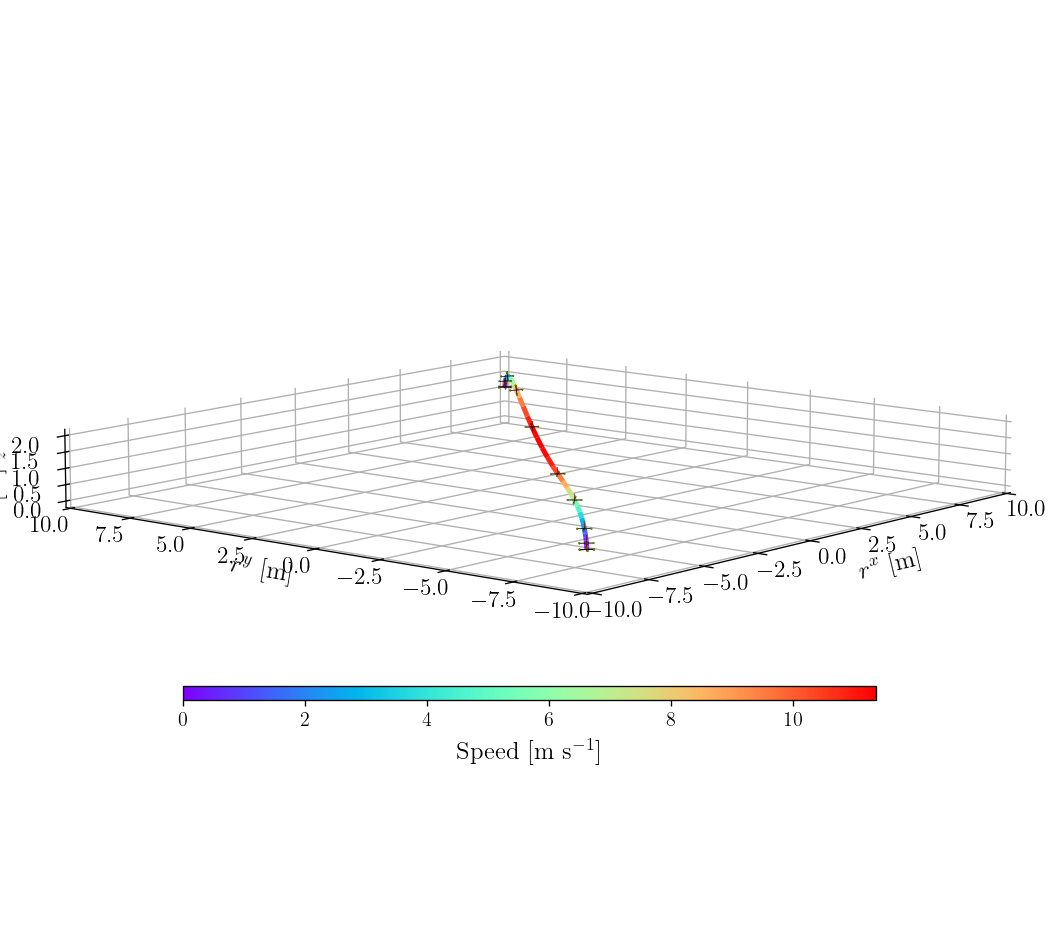

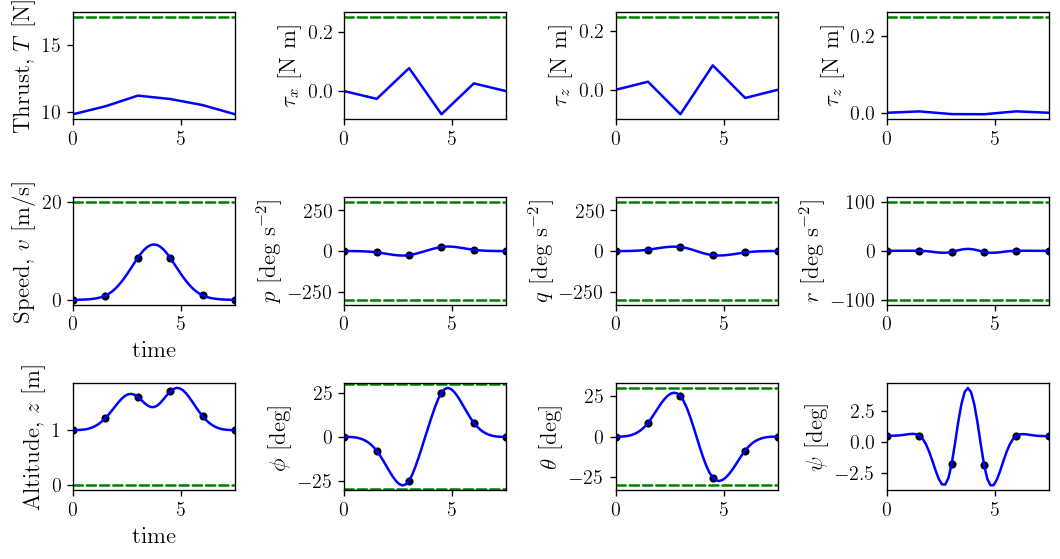

In [929]:
qf_plot(qf_results, qf_params)

### Animation

In [930]:
if save_anim:
    qf_animation(qf_results, qf_params, delt=2)
    make_anim(load_from = 'sim/', 
              save_to = 'quad_flight',
              duration = 5.0, 
              fps = 24, 
              anim_format = 'gif')
    
